In [1]:
import glob
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
import seaborn as sb
import segmentation_models as sm
import functools as ft
import pandas as pd

# disable GPU computation
# tf.config.set_visible_devices([], 'GPU')

sm.set_framework('tf.keras')
sm.framework()

tf.random.set_seed(1024)
SEED = 100

Segmentation Models: using `keras` framework.


In [2]:
def get_image_decode(image, label):
    image = tf.io.read_file(image, "image")
    label = tf.io.read_file(label, "label")

    image = tf.image.decode_image(image)
    label = tf.image.decode_image(label)

    return image, label


# [w, h, c], 448, 448, 3
def decode_crop(image, label):
    image = image[256 // 2 : -(256 // 2), 368 // 2 : -(368 // 2)]
    label = label[256 // 2 : -(256 // 2), 368 // 2 : -(368 // 2)]

    img_array = []
    label_array = []

    for index in range(8 * 4):
        x, y = index // 8, index % 4
        img_array.append(image[448 * x : 448 * (1 + x), 448 * y : 448 * (1 + y)])
        label_array.append(label[448 * x : 448 * (1 + x), 448 * y : 448 * (1 + y)])

    return tf.data.Dataset.from_tensor_slices((img_array, label_array))


def get_mask(image, label):
    labels = []
    labels.append((label[:, :, 0] == 0) & (label[:, :, 1] == 0) & (label[:, :, 2] == 0))
    labels.append(
        (label[:, :, 0] == 128) & (label[:, :, 1] == 0) & (label[:, :, 2] == 0)
    )
    labels.append(
        (label[:, :, 0] == 128) & (label[:, :, 1] == 64) & (label[:, :, 2] == 128)
    )
    labels.append(
        (label[:, :, 0] == 0) & (label[:, :, 1] == 128) & (label[:, :, 2] == 0)
    )
    labels.append(
        (label[:, :, 0] == 128) & (label[:, :, 1] == 128) & (label[:, :, 2] == 0)
    )
    labels.append(
        (label[:, :, 0] == 64) & (label[:, :, 1] == 0) & (label[:, :, 2] == 128)
    )
    labels.append(
        (label[:, :, 0] == 192) & (label[:, :, 1] == 0) & (label[:, :, 2] == 192)
    )
    labels.append(
        (label[:, :, 0] == 64) & (label[:, :, 1] == 64) & (label[:, :, 2] == 0)
    )
    labels = tf.cast(labels, tf.float32)
    image = tf.cast(image, tf.float32)

    # must perform this
    return image, tf.transpose(labels, [1, 2, 0])


def create_ds(batch_size, istrain=True, maximage=False):
    AUTOTUNE = tf.data.AUTOTUNE

    if istrain:
        directory = "/home/hackerton/Downloads/uavid_v1.5_official_release/uavid_train/**/Images/*.png"
        images = glob.glob(directory, recursive=True)
        directory = "/home/hackerton/Downloads/uavid_v1.5_official_release/uavid_train/**/Labels/*.png"
        labels = glob.glob(directory, recursive=True)
    else:
        directory = "/home/hackerton/Downloads/uavid_v1.5_official_release/uavid_val/**/Images/*.png"
        images = glob.glob(directory, recursive=True)
        directory = "/home/hackerton/Downloads/uavid_v1.5_official_release/uavid_val/**/Labels/*.png"
        labels = glob.glob(directory, recursive=True)

    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    ds = ds.cache()
    if istrain:
        ds = ds.shuffle(6400, SEED, reshuffle_each_iteration=True)
    ds = ds.map(get_image_decode, AUTOTUNE)

    if not maximage:
        ds = ds.flat_map(decode_crop)

    ds = ds.map(get_mask, AUTOTUNE)

    # batch and prefetch
    ds = ds.batch(batch_size)

    if istrain:
        ds = ds.prefetch(AUTOTUNE)

    return ds


In [3]:
# data = create_ds(1, False, True)

# total_mask_sum = tf.zeros([8], tf.int64)
# for image, mask in data:
#     mask = tf.cast(mask, tf.int64)
#     mask_sum = tf.reduce_sum(mask, [0, 1, 2])

#     total_mask_sum += mask_sum

In [4]:
# plt.figure(figsize=(15, 7))
# plt.bar([str(i) for i in range(8)], total_mask_sum / tf.reduce_max(total_mask_sum), color=['blue', 'red', 'green', 'yellow'], align='center', alpha=0.8)
# plt.grid(True)
# plt.title('The number of samples mask in each class')

# (total_mask_sum / tf.reduce_mean(total_mask_sum))

In [5]:
def create_backbone():
    _backbone = tf.keras.applications.EfficientNetB0(
        include_top=False, input_shape=[None, None, 3]
    )

    outputs = [
        layer.output
        for layer in _backbone.layers
        if layer.name
        in [
            "block2a_activation",
            "block3a_activation",
            "block5a_activation",
            "block7a_activation",
        ]
    ]

    return tf.keras.Model(
        inputs=[_backbone.input], outputs=outputs, name="efficientb0_backbone"
    )


class FPN(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(name="Feature_Pyramid_Network", **kwargs)

        self.backbone = create_backbone()
        self.conv5_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv4_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv3_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv2_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv5_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv5_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv5_bn = tf.keras.layers.BatchNormalization()
        self.conv4_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv4_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv4_bn = tf.keras.layers.BatchNormalization()
        self.conv3_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv3_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv3_bn = tf.keras.layers.BatchNormalization()
        self.conv2_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv2_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv2_bn = tf.keras.layers.BatchNormalization()
        self.upscale = tf.keras.layers.UpSampling2D(size=(2, 2))

    def call(self, images, training=False):
        # 112x112, 56x56, 28x28, 14x14
        conv2, conv3, conv4, conv5 = self.backbone(images, training=training)
        conv5_m = self.conv5_1x1(conv5)
        conv5_p = self.conv5_3x3_1(conv5_m)
        conv5_p = self.conv5_3x3_2(conv5_p)
        conv5_p = self.conv5_bn(conv5_p, training=training)

        conv4_m_1 = self.upscale(conv5_m)
        conv4_m_2 = self.conv4_1x1(conv4)
        conv4_m = conv4_m_1 + conv4_m_2
        conv4_p = self.conv4_3x3_1(conv4_m)
        conv4_p = self.conv4_3x3_2(conv4_p)
        conv4_p = self.conv4_bn(conv4_p, training=training)

        conv3_m_1 = self.upscale(conv4_m)
        conv3_m_2 = self.conv3_1x1(conv3)
        conv3_m = conv3_m_1 + conv3_m_2
        conv3_p = self.conv3_3x3_1(conv3_m)
        conv3_p = self.conv3_3x3_2(conv3_p)
        conv3_p = self.conv3_bn(conv3_p, training=training)

        conv2_m_1 = self.upscale(conv3_m)
        conv2_m_2 = self.conv2_1x1(conv2)
        conv2_m = conv2_m_1 + conv2_m_2
        conv2_p = self.conv2_3x3_1(conv2_m)
        conv2_p = self.conv2_3x3_2(conv2_p)
        conv2_p = self.conv2_bn(conv2_p, training=training)
        return conv5_p, conv4_p, conv3_p, conv2_p


class FCN(tf.keras.Model):
    def __init__(self, n_classes=8, **kwargs):
        super().__init__(name="FCN", **kwargs)
        self.fpn = FPN()
        self.upscale_2x = tf.keras.layers.UpSampling2D()
        self.upscale_4x = tf.keras.layers.UpSampling2D((4, 4))
        self.upscale_8x = tf.keras.layers.UpSampling2D((8, 8))
        self.concat = tf.keras.layers.Concatenate()
        self.conv6 = tf.keras.layers.Conv2D(
            filters=(512), kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.bnorm = tf.keras.layers.BatchNormalization()
        self.conv7 = tf.keras.layers.Conv2D(
            filters=n_classes, kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.upscale_final = tf.keras.layers.UpSampling2D(
            size=(4, 4), interpolation="bilinear"
        )
        self.final_activation = tf.keras.layers.Activation("softmax")

    def set_trainable(self, state=False):
        for layer in self.fpn.backbone.layers:
            layer.trainable = state

    def call(self, images, training=False):
        conv5_p, conv4_p, conv3_p, conv2_p = self.fpn(images, training=training)
        m_5 = self.upscale_8x(conv5_p)
        m_4 = self.upscale_4x(conv4_p)
        m_3 = self.upscale_2x(conv3_p)
        m_2 = conv2_p

        m_all = self.concat([m_2, m_3, m_4, m_5])
        m_all = self.conv6(m_all)
        m_all = self.bnorm(m_all, training=training)
        m_all = self.conv7(m_all)
        m_all = self.upscale_final(m_all)
        m_all = self.final_activation(m_all)

        return m_all


class FCN_ORIG(tf.keras.Model):
    def __init__(self, n_classes=8, **kwargs):
        super().__init__(name="FCN_ORIG", **kwargs)

        self.backbone = create_backbone()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=(n_classes), kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv2D(
            filters=(n_classes), kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv2D(
            filters=(n_classes), kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.upscale2x_1 = tf.keras.layers.Convolution2DTranspose(
            filters=8,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding="same",
            activation="relu",
        )
        self.upscale2x_2 = tf.keras.layers.Convolution2DTranspose(
            filters=8,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding="same",
            activation="relu",
        )
        self.upscale8x = tf.keras.layers.Convolution2DTranspose(
            filters=8,
            kernel_size=(16, 16),
            strides=(8, 8),
            padding="same",
            activation="relu",
        )
        self.final_activation = tf.keras.layers.Activation("softmax")

    def call(self, images, training=False):
        _, conv1_o, conv2_o, conv3_o = self.backbone(images, training=training)
        conv1_o = self.conv1(conv1_o)
        conv2_o = self.conv2(conv2_o)
        conv3_o = self.conv3(conv3_o)

        fcn_16x = self.upscale2x_1(conv3_o) + conv2_o
        fcn_8x = self.upscale2x_2(fcn_16x) + conv1_o
        final_output = self.upscale8x(fcn_8x)
        final_output = self.final_activation(final_output)
        return final_output


In [6]:
# the network must OUTPUT in logits [-inf, inf]
def Jindex(target, pred):
    intersection = tf.reduce_sum(target * pred, [0, 1, 2])
    union = tf.reduce_sum(target + pred, [0, 1, 2]) - intersection
    return tf.reduce_mean(intersection / union)


# # I hypothesis from_logits is the cause of NaN
def loss_fn(target, sample, weight, alpha=1, beta=0.5):
    loss = alpha * tf.reduce_mean(
        tf.keras.losses.categorical_crossentropy(target, sample),
    )
    return loss + beta * (1 - Jindex(target, sample, weight))


In [7]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [8]:
# this iteration is calculated fom 160 iteration from
# paper
n_epoch = 20
n_classes = 8
ds = create_ds(1)
test = create_ds(1, False)
# model = FCN(8)
# model = sm.Unet(backbone_name='resnet50', encoder_weights='imagenet', encoder_freeze=False, activation='softmax', classes=8)
model = FCN_ORIG(8)

In [9]:
# lr = 0.001 is good but spiky, next learning rate to test is 0.0005

# both fpn and unet uses 1e-4 learning rate
optimizer = tf.keras.optimizers.Adam(0.00002)
dice_loss = sm.losses.CategoricalFocalLoss()
focal_loss = sm.losses.DiceLoss()


In [10]:
ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
ckptmg = tf.train.CheckpointManager(ckpt, 'new_orig_fcn', 5)
ckptmg.restore_or_initialize()

In [11]:
# normalize gradient for pretrained network
iteration = 0

# REMEMBER TO CHANGE THIS BACK to nepoch
for _ in range(n_epoch):
    total_loss = 0
    total_num = 0
    total_iou = 0
    for bs_images, bs_labels in ds:
        # REMEMBER HERE
        # Comment this if you are training FPN and ORIG_FCN
        # bs_images = sm.get_preprocessing('resnet')(bs_images)

        with tf.GradientTape() as t:
            output = model(bs_images)
            c_loss = dice_loss(bs_labels, output) + 0.5 * focal_loss(bs_labels, output)

        total_num += 1
        total_loss += c_loss.numpy()
        total_iou += sm.metrics.iou_score(bs_labels, output)
        iteration += 1

        grad = t.gradient(c_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables))

        with train_summary_writer.as_default():
            tf.summary.scalar("iou", total_iou / total_num, step=iteration)
            tf.summary.scalar("loss", total_loss / total_num, step=iteration)


    total_iou_test = 0
    total_loss_test = 0
    total_num_test = 0
    for bs_images, bs_labels in test:
        output = model(bs_images, training=False)

        total_num_test += 1
        total_loss_test += dice_loss(bs_labels, output) + 0.5 * focal_loss(
            bs_labels, output
        )
        total_iou_test += sm.metrics.iou_score(bs_labels, output)

    with test_summary_writer.as_default():
        tf.summary.scalar("iou", total_iou_test / total_num_test, step=iteration)
        tf.summary.scalar("loss", total_loss_test / total_num_test, step=iteration)

    ckptmg.save()


# To explain about LABELS

1. Background Clutter (0, 0, 0)
2. Building           (128, 0, 0)
3. Road               (128, 64, 128)
4. Tree               (0, 128, 0)
5. Low Vegetation     (128, 128, 0)
6. Moving Car         (64, 0, 128)
7. Static Car         (192, 0, 192)
8. Human              (64, 64, 0)

In [12]:
num = 0
total_iou = 0
classes_iou = tf.zeros([8])

test = create_ds(1, False, True)

for d, y in test.take(1):
    # add 8 padding horizontally
    d = sm.get_preprocessing('resnet50')(d)
    out_img = model(tf.pad(d, [[0, 0], [8, 8], [0, 0], [0,0]]), training=False)
    y = tf.pad(y, [[0, 0], [8, 8], [0, 0], [0,0]])

    fig, axs = plt.subplots(1, 8, figsize=(20, 20))
    for i, ax in enumerate(axs.flat):
        ax.imshow(y[0, :, :, i])

    fig, axs = plt.subplots(1, 8, figsize=(20, 20))
    for i, ax in enumerate(axs.flat):
        ax.imshow(out_img[0, :, :, i])

    num += 1
    # total_iou += sm.metrics.iou_score(y, out_img).numpy()
    intersection = tf.reduce_sum(out_img * y, [0, 1, 2])
    union = tf.reduce_sum(out_img + y, [0, 1, 2]) - intersection
    classes_iou += intersection / union

print(classes_iou / num)

ResourceExhaustedError: OOM when allocating tensor with shape[1,32,1088,2048] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

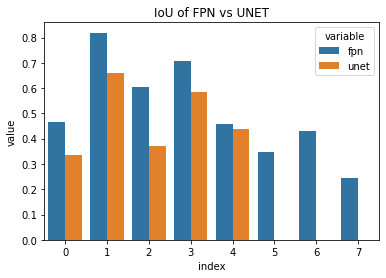

In [ ]:
# result for FPN
result_fpn = [
    0.46724114,
    0.8189325,
    0.6044639,
    0.7086379,
    0.45720816,
    0.34781703,
    0.42935002,
    0.24366052,
]

# result for UNET
result_unet = [
    3.3367285e-01,
    6.6008663e-01,
    3.7074447e-01,
    5.8561021e-01,
    4.3773600e-01,
    0.0000000e00,
    7.9385777e-20,
    1.1507687e-23,
]


results = pd.DataFrame(
    {"fpn": result_fpn, "unet": result_unet},
)

results = results.melt()
results["index"] = [i % 8 for i in range(16)]
fig, ax = plt.subplots()

ax.set_title("IoU of FPN vs UNET")
sb.barplot(data=results, x="index", y="value", hue="variable")

In [ ]:
# iou loss
intersection = tf.reduce_sum(out_img * y, [0, 1, 2])
union = tf.reduce_sum(out_img + y, [0, 1, 2]) - intersection
# print(tf.reduce_mean(intersection / union))
(intersection / union).numpy()

array([0.5063492 , 0.83595437, 0.40129408, 0.7200879 , 0.5190978 ,
       0.        , 0.2961473 , 0.07226681], dtype=float32)

In [ ]:
# dice loss
intersection = tf.reduce_sum(2 * out_img * y, [0, 1, 2])
union = tf.reduce_sum(out_img + y, [0, 1, 2])
print(tf.reduce_mean(intersection / union))
intersection / union

tf.Tensor(0.53351736, shape=(), dtype=float32)


<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([0.6722866 , 0.9106483 , 0.5727478 , 0.83726865, 0.68342906,
       0.        , 0.4569655 , 0.13479258], dtype=float32)>

In [ ]:
def to_save(images, name):
    for idx in range(images[0].shape[-1]):
        byte = tf.image.encode_jpeg(tf.image.convert_image_dtype(images[0, ..., idx][..., tf.newaxis], tf.uint8))
        tf.io.write_file(f'{name}_{idx}_image.jpeg', byte)

to_save(out_img, 'test')
# to_save(y, 'target')